In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat


In [3]:
linearcoord = loadmat('/stelmo/anna/remy/filterframework/decoding/new_arm_nodes.mat')['linearcoord_one_box'][0]



In [4]:
from loren_frank_data_processing.position import _get_pos_dataframe
from  loren_frank_data_processing import Animal
ANIMALS = {
    'remy': Animal(directory=('/stelmo/anna/remy/filterframework/'), short_name='remy'),
}
epoch_key = ('remy',20,2)
position_info = _get_pos_dataframe(epoch_key, ANIMALS)

/home/anna/anaconda3/envs/clusterless/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


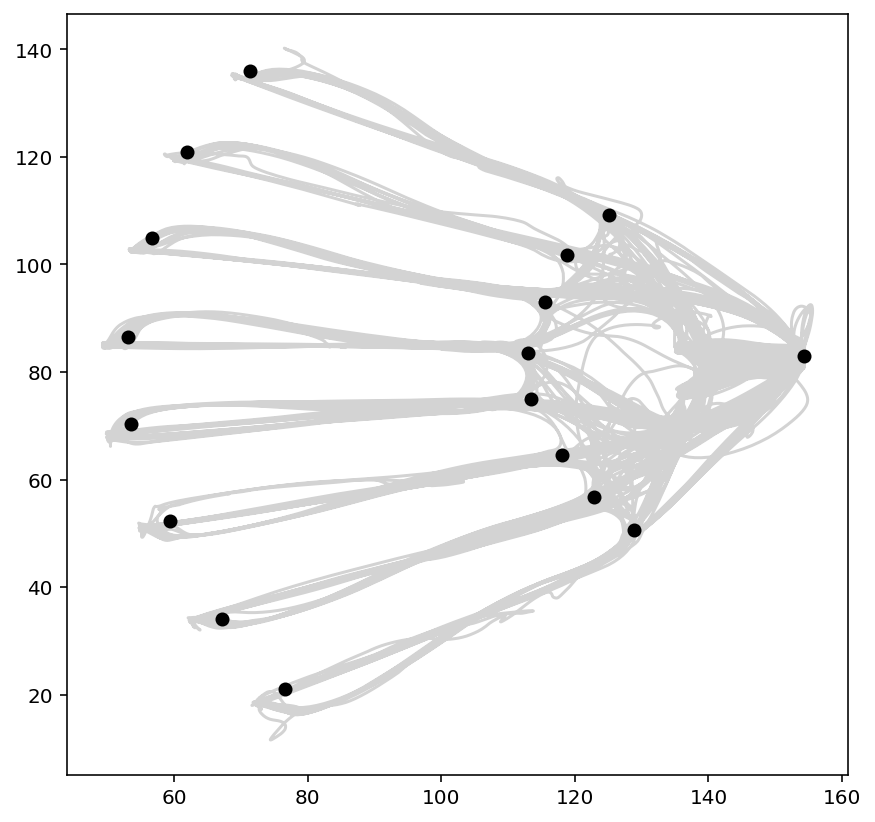

In [5]:
center_well_position = linearcoord[0][0]
nodes = [center_well_position[np.newaxis, :]]
for arm in linearcoord:
    for point in arm[1:]:
        nodes.append(point[np.newaxis, :])

nodes = np.concatenate(nodes)
plt.figure(figsize=(7, 7))
plt.plot(position_info.x_position, position_info.y_position, color='lightgrey')
plt.scatter(nodes[:, 0], nodes[:, 1], zorder=10, color='black')

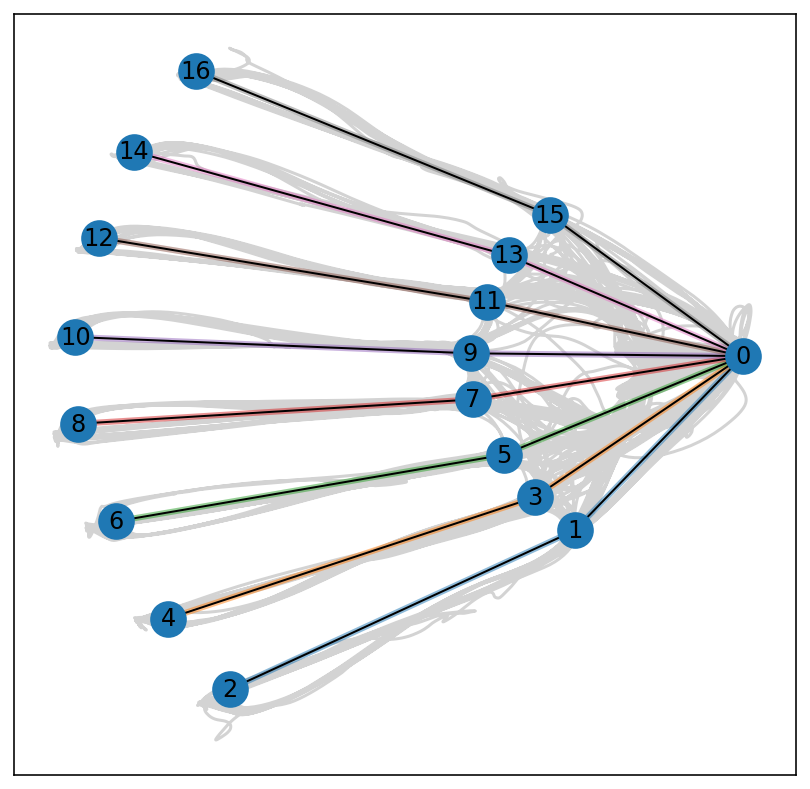

In [6]:
dist = []
for arm in linearcoord:
    dist.append(np.linalg.norm(np.diff(arm, axis=0), axis=1))

np.stack([*dist])
edges = [(0, 1),
(1, 2),
(0, 3),
(3, 4),
(0, 5),
(5, 6),
(0, 7),
(7, 8),
(0, 9),
(9, 10),
(0, 11),
(11, 12),
(0, 13),
(13, 14),
(0, 15),
(15, 16)]
edge_distances = np.concatenate([*dist])
import networkx as nx
from loren_frank_data_processing.track_segment_classification import plot_track
plt.figure(figsize=(7, 7))
plt.plot(position_info.x_position, position_info.y_position, color='lightgrey', zorder=-1)
track_graph = nx.Graph()
for node_id, node_position in enumerate(nodes):
    track_graph.add_node(node_id, pos=tuple(node_position))
for edge, distance in zip(edges, edge_distances):
    track_graph.add_edge(edge[0], edge[1], distance=distance)
for arm in linearcoord:
    plt.plot(arm[:, 0], arm[:, 1], linewidth=3, zorder=0, alpha=0.5)
plot_track(track_graph)

In [ ]:
position_info

In [7]:
from loren_frank_data_processing.track_segment_classification import classify_track_segments
position = position_info.loc[:, ['x_position', 'y_position']].values
track_segment_id = classify_track_segments(
 track_graph, position,
 route_euclidean_distance_scaling=1,
 sensor_std_dev=1)

In [ ]:
#position_info['track_segment_id'].fillna(method='backfill',inplace=True)
position_info

In [ ]:
plt.figure(figsize=(7, 7))
plt.scatter(position[:, 0], position[:, 1], c=position_info['track_segment_id'],
 cmap='tab20', s=10)
plt.scatter(nodes[:, 0], nodes[:, 1], zorder=10, color='black')

In [ ]:
from loren_frank_data_processing.track_segment_classification import calculate_linear_distance
center_well_id = 0
(position_info["linear_distance"],position_info["projected_x_position"],position_info["projected_y_position"]) = calculate_linear_distance(track_graph, position_info['track_segment_id'], center_well_id, position)

In [ ]:
position_info['linear_distance'].fillna(method='backfill',inplace=True)
position_info['track_segment_id'].fillna(method='backfill',inplace=True)
position_info

In [ ]:
position_info['track_segment_id'].where(position_info['track_segment_id']<0,np.nan,inplace=True)
position_info

In [ ]:
plt.figure(figsize=(20, 5))
time = position_info.index / np.timedelta64(1,'s')
plt.scatter(time, position_info['linear_distance'],
 s=10, c=track_segment_id, cmap='tab20')
#plt.xlim((time.min(), time.max()))
plt.xlim((2000, 2500))

In [ ]:
plt.figure(figsize=(7, 7))
plt.scatter(position_info['projected_x_position'], position_info['projected_y_position'], c=track_segment_id,
 cmap='tab20', s=10)
plt.scatter(nodes[:, 0], nodes[:, 1], zorder=10, color='black')

In [ ]:
linearcoord = loadmat('/home/anna/Src/Python/fievel_new_arm_nodes.mat')['linearcoord_one_box'][0]
center_well_position = linearcoord[0][0]
nodes = [center_well_position[np.newaxis, :]]
for arm in linearcoord:
    for point in arm[1:]:
        nodes.append(point[np.newaxis, :])

nodes = np.concatenate(nodes)
plt.figure(figsize=(7, 7))
plt.plot(position_info.x_position, position_info.y_position, color='lightgrey')
plt.scatter(nodes[:, 0], nodes[:, 1], zorder=10, color='black')

In [ ]:
arm_distances = (edge_distances[1],edge_distances[3],edge_distances[5],edge_distances[7],
                        edge_distances[9],edge_distances[11],edge_distances[13],edge_distances[15])

shift_linear_distance_by_arm_dictionary = dict() # initialize empty dictionary 

hardcode_armorder = [0,1,2,3,4,5,6,7]
gap_size=20
for arm in enumerate(hardcode_armorder): # for each outer arm
    if arm[0] == 0: # if first arm, just shift hardcode_shiftamount
        temporary_variable_shift = gap_size
    else: # if not first arm, add to hardcode_shiftamount length of previous arm 
        temporary_variable_shift = gap_size + arm_distances[arm[0]] + shift_linear_distance_by_arm_dictionary[hardcode_armorder[arm[0] - 1]]
    shift_linear_distance_by_arm_dictionary[arm[1]] = temporary_variable_shift

        # Modify: 1) collapse non-arm locations (segments 0-7), 
        # 2) shift linear distance for the 8 arms (segments 8-15)
newseg = np.copy(position_info['track_segment_id'])
newseg[(newseg < 8)] = 0

In [ ]:
linear_distance_arm_shift = np.copy(position_info['linear_distance'])
for seg in shift_linear_distance_by_arm_dictionary:
    linear_distance_arm_shift[(newseg==(seg+8))]+=shift_linear_distance_by_arm_dictionary[(seg)]  

In [ ]:
plt.figure(figsize=(20, 5))
time = position_info.index / np.timedelta64(1,'s')
plt.scatter(time, linear_distance_arm_shift,
 s=10, c=newseg, cmap='tab20')
plt.xlim((time.min(), time.max()))

In [ ]:
#lindist_floor = np.floor(linear_distance_arm_shift)
lindist_floor = linear_distance_arm_shift

In [ ]:
def turn_array_into_ranges(array1):
    array1_diff = np.ediff1d(array1)

    start_temp = [] 
    end_temp = []
    start_temp.append(array1[0]) 

    some_end_indices = np.where(array1_diff > 1)

    for i in range(len(some_end_indices[0])):
        # This is always an end index
        end_temp.append(array1[some_end_indices[0][i]])
        if array1[some_end_indices[0][i]] == start_temp[i]: # if this is the same as the last start index, it was already added as a start index-- don't need to add it again
            start_temp.append(array1[some_end_indices[0][i] + 1]) # define next start index   
        elif array1_diff[some_end_indices[0][i] - 1] > 1: # if last value was more than 1 away, this is also a start index
            start_temp.append(array1[some_end_indices[0][i]])    
        else: # if last value was NOT more than 1 away, this is JUST an end index, and next start index is next index
            start_temp.append(array1[some_end_indices[0][i] + 1])   
    # The last entry in array is always the last end index
    end_temp.append(array1[-1])  

    return start_temp, end_temp

In [ ]:
track_segments = np.unique(newseg)
seg_pos_range = []
seg_pos_range_edges = [] 
for seg in track_segments:
    seg_inds = newseg==seg      #get index of positions on that segment
    seg_pos = lindist_floor[seg_inds]    # store those positions (pos only, not vel)
    seg_pos_range.append([seg_pos.min() ,seg_pos.max()])    # get min and max vals per segment
    seg_pos_range_edges.append([np.floor(seg_pos.min()), np.ceil(seg_pos.max())])

binswewant_tmp = []
for seg_range in np.floor(seg_pos_range_edges): # for each track segment
    binswewant_tmp.append(np.arange(seg_range[0],seg_range[1]+1)) # + 1 to account for np.arange not including last index

occupied_bins = np.unique(np.concatenate(binswewant_tmp))   # concatenate and get rid of duplicate bins from box segs
arm_coordinates = np.column_stack(turn_array_into_ranges(occupied_bins))   #  get start & end of each region

In [ ]:
seg_pos_range_edges

In [ ]:
armcoordinates_corrected = []
pos_bins = []
for arm in np.arange(0,arm_coordinates.shape[0],1):
    arm_bounds = arm_coordinates[arm]
        # add to arm edge value to make it divisible by posbin. each arm starts at the node, and now will end some 5cm bins later
    remainder = np.mod((arm_bounds[1]-arm_bounds[0]),5)   
    if remainder: 
        extra_needed = 5-remainder     
    else:
        extra_needed = 0
    new_bounds = [arm_bounds[0], arm_bounds[1]+extra_needed]
    armcoordinates_corrected.append(new_bounds)
        # construct pos bin edges. this is not just a range, because the gaps are not strictly 5cm (thanks to the adjustments above)
    pos_bins.append(np.arange(new_bounds[0],new_bounds[1]+1,5))   
    if arm_bounds[1] < arm_coordinates[-1,-1]:  
        pos_bins.append(np.arange(new_bounds[1],arm_coordinates[arm+1][0]+1,5))  # add gap bins
        

In [ ]:
pos_bins = np.unique(np.concatenate(pos_bins))  # analog to mike's position_bins
print(pos_bins)

armcoordinates_binned = []     # find the indexes of the arm ends (mike's new_arm_coords)
for end in armcoordinates_corrected:
    startind=np.where(pos_bins == end[0])
    endind = np.where(pos_bins == end[1])
    armcoordinates_binned.append([startind[0][0],endind[0][0]-1])
armcoordinates_binned = np.array(armcoordinates_binned)

print(armcoordinates_binned)

    # bin linearized position data with these bins
    # digitize returns the bin index for each value, converting position measure into binindex measure (1-based)
digitized = np.digitize(lindist_floor, pos_bins)
binned_linear_pos = digitized-1  # -1  for python 0-based

In [ ]:

armcoordinates_binned = []     # find the indexes of the arm ends (mike's new_arm_coords)
for end in armcoordinates_corrected:
    startind=np.where(pos_bins == end[0])
    endind = np.where(pos_bins == end[1])
    armcoordinates_binned.append([startind[0][0],endind[0][0]])
armcoordinates_binned = np.array(armcoordinates_binned)

In [ ]:
armcoordinates_binned[:,1] = 1+armcoordinates_binned[:,1]
armcoordinates_binned

In [ ]:
for i in np.arange(0,len(pos_bins),1):  #iterate through pos bins (excludes box end)
    if i in armcoordinates_binned[1:,1]:
        print(pos_bins[i])
#pos_in_bin = pos_raw['linpos_flat'][(pos_raw['linpos_flat']>pos_bins[i]) & (pos_raw['linpos_flat']<pos_bins[i+1])]

In [ ]:
pos_delta = np.ones(armcoordinates_binned[-1][-1]+1)
for i in np.arange(0,len(pos_bins)+1,1):  #iterate through pos bins (excludes box end)
    if i in armcoordinates_binned[1:,1]:     # calc coverage if this is an arm end bin
        pos_in_bin = lindist_floor[(lindist_floor>=pos_bins[i-1]) & (lindist_floor<pos_bins[i])]  
        pos_delta[i] = (max(pos_in_bin)-pos_bins[i])/5
        print(pos_in_bin)

In [ ]:
enc_spikes_range = np.arange(0,len(tet_lin_pos['linpos_flat']),1)
            pos_distrib_tet = np.zeros((len(tet_lin_pos['linpos_flat']),len(encode_settings.pos_bins)))
            pos_distrib_tet[np.expand_dims(enc_spikes_range, 1),np.expand_dims(tet_lin_pos['linpos_flat'], 1)] = 1

In [ ]:
len(pos_bins)


In [ ]:
plt.figure(figsize=(20, 5))
time = position_info.index / np.timedelta64(1,'s')
plt.scatter(time, binned_linear_pos,
 s=10, c=newseg, cmap='tab20')
plt.xlim((11025, 11035))

In [ ]:
plt.figure(figsize=(20, 5))
plt.hist(binned_linear_pos,np.arange(0,138.5, .5))

In [ ]:
binned_linear_pos.max()